# Exercise 1 - K-Nearest Neighbor Classifier for MNIST

In this exercise, we'll apply KNN Classifiers to the MNIST dataset. The aim of the exercise is to get acquainted with the MNIST dataset. 

This guide uses [tf.keras](https://www.tensorflow.org/guide/keras), a high-level API to build and train models in TensorFlow.

## Install and import dependencies

We'll need [TensorFlow Datasets](https://www.tensorflow.org/datasets/), an API that simplifies downloading and accessing datasets, and provides several sample datasets to work with. We're also using a few helper libraries.

In [1]:
!pip install -U tensorflow_datasets

     |████████████████████████████████| 3.1 MB 6.1 MB/s eta 0:00:01
  Attempting uninstall: tensorflow-datasets
    Found existing installation: tensorflow-datasets 2.0.0
    Uninstalling tensorflow-datasets-2.0.0:
      Successfully uninstalled tensorflow-datasets-2.0.0


In [2]:
# Import TensorFlow

# FOR COLAB USERS:
# If you run this notebook in Colab, then execute the following line (uncomment it)
# %tensorflow_version 2.x


# If you run this noteook in your tensorflow 2.x environment, then 
# verify you have version > 2.0

import tensorflow as tf
print(tf.__version__)

# Now you should get version 2.x
# If you still get version 1.x, then execute (uncomment) the following lines and run the cell

#!pip uninstall tensorflow
#!pip install --upgrade pip
#!pip install --upgrade tensorflow
#!python3 -c "import tensorflow as tf;print(tf.reduce_sum(tf.random.normal([1000, 1000])))"
#try:
#  import tensorflow as tf
#except Exception:
#  pass
#print(tf.__version__)


2.1.0


In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals


# Import TensorFlow Datasets
import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt


In [4]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)
!python -V

Python 3.6.8


## Import the MNIST dataset

This guide uses the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset—often used as the "Hello, World" of machine learning programs for computer vision. The MNIST dataset contains images of handwritten digits (0, 1, 2, etc)


We will use 60,000 images to train the network and 10,000 images to evaluate how accurately the network learned to classify images. You can access the MNIST directly from TensorFlow, using the [Datasets](https://www.tensorflow.org/datasets) API:

In [6]:
dataset, metadata = tfds.load('mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Loading the dataset returns metadata as well as a *training dataset* and *test dataset*.

* The model is trained using `train_dataset`.
* The model is tested against `test_dataset`.

The images are 28 $\times$ 28 arrays, with pixel values in the range `[0, 255]`. The *labels* are an array of integers, in the range `[0, 9]`. These correspond to the handwritten numbers. 


Each image is mapped to a single label. Since the *class names* are not included with the dataset, store them here to use later when plotting the images:

In [7]:
class_names = ['Zero', 'One', 'Two', 'Three', 'Four', 'Five',
               'Six',  'Seven',   'Eight',  'Nine']


### Explore the data

Let's explore the format of the dataset before training the model. The following shows there are 60,000 images in the training set, and 10000 images in the test set:

In [8]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))

Number of training examples: 60000
Number of test examples:     10000


Let's plot an image to see what it looks like.

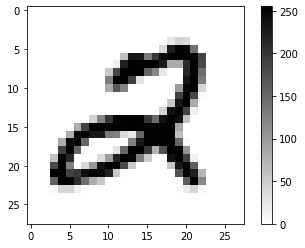

In [9]:
# Take a single image, and remove the color dimension by reshaping
for image, label in test_dataset.take(1):
  break
image = image.numpy().reshape((28,28))

# Plot the image - voila an example of a handwritten digit
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

Display the first 25 images from the *test set* and display the class name below each image. Verify that the data is in the correct format and we're ready to build and train the network.

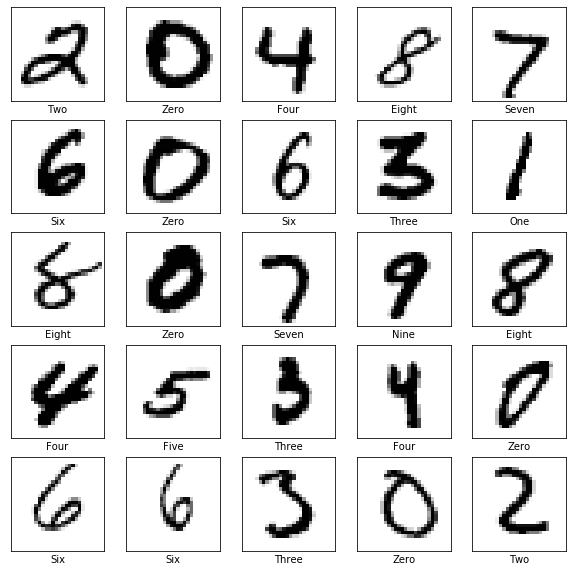

In [10]:
plt.figure(figsize=(10,10))
i = 0
for (image, label) in test_dataset.take(25):
    image = image.numpy().reshape((28,28))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[label])
    i += 1
plt.show()

## Import the Fashion MNIST dataset

If numbers are not your thing then use the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset, which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 $\times$ 28 pixels), as seen here:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite" width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

You may use Fashion MNIST for variety, and because it's a slightly more challenging problem than regular MNIST. Both datasets are relatively small and are used to verify that an algorithm works as expected. They're good starting points to test and debug code.

We will use 60,000 images to train the network and 10,000 images to evaluate how accurately the network learned to classify images. You can access the Fashion MNIST directly from TensorFlow, using the [Datasets](https://www.tensorflow.org/datasets) API:

In [11]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Loading the dataset returns metadata as well as a *training dataset* and *test dataset*.

* The model is trained using `train_dataset`.
* The model is tested against `test_dataset`.

The images are 28 $\times$ 28 arrays, with pixel values in the range `[0, 255]`. The *labels* are an array of integers, in the range `[0, 9]`. These correspond to the *class* of clothing the image represents:

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

Each image is mapped to a single label. Since the *class names* are not included with the dataset, store them here to use later when plotting the images:

In [12]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

### Explore the data

Let's explore the format of the dataset before training the model. The following shows there are 60,000 images in the training set, and 10000 images in the test set:

In [13]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))

Number of training examples: 60000
Number of test examples:     10000


Let's plot an image to see what it looks like.

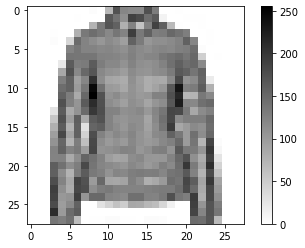

In [14]:
# Take a single image, and remove the color dimension by reshaping
for image, label in test_dataset.take(1):
  break
image = image.numpy().reshape((28,28))

# Plot the image - voila a piece of fashion clothing
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

Display the first 25 images from the *test set* and display the class name below each image. Verify that the data is in the correct format and we're ready to build and train the network.

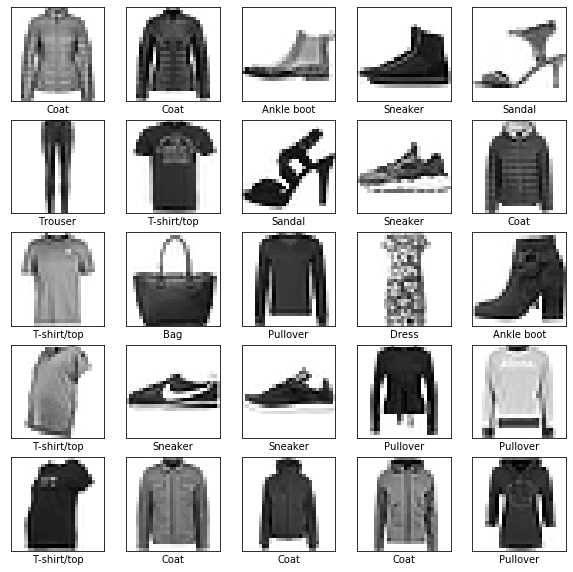

In [16]:
plt.figure(figsize=(10,10))
i = 0
for (image, label) in test_dataset.take(25):
    image = image.numpy().reshape((28,28))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[label])
    i += 1
plt.show()

Decide whether you want to work with the traditional or Fashin MNIST dataset, then extract 5000 training examples and 
500 test examples.

In [17]:
i=0
for (image, label) in train_dataset.take(5000):
    if i==0:
        X_train = image.numpy().reshape((1,28*28))
        y_train = np.array([label])
    else:
        X_train = np.concatenate([X_train, image.numpy().reshape((1,28*28))], axis=0)
        y_train = np.concatenate([y_train, np.array([label])], axis=0)
    i+=1
print("Shape of image training data : ", X_train.shape)
print("Shape of training data labels : ", y_train.shape)

Shape of image training data :  (5000, 784)
Shape of training data labels :  (5000,)


In [18]:
j=0
for (image, label) in test_dataset.take(500):
    if j==0:
        X_test = image.numpy().reshape((1,28*28))
        y_test = np.array([label])
    else:
        X_test = np.concatenate([X_test, image.numpy().reshape((1,28*28))], axis=0)
        y_test = np.concatenate([y_test, np.array([label])], axis=0)
    j+=1
print("Shape of image test data : ", X_test.shape)
print("Shape of test data labels : ", y_test.shape)

Shape of image test data :  (500, 784)
Shape of test data labels :  (500,)


# Exercises

1. Apply Nearest Neighbour with L1 distance to this subset of the dataset and determine the accuracy on the 
test dataset and plot the confusion matrix.

2. Apply K-Nearest Neighbour with $k=5$ and L2 distance to this subset of the dataset and determine the accuracy on the test dataset and plot the confusion matrix.

3. Determine by means of 5-fold cross-validation the best value of $k$ in the set $\{1,4,5,10,12,18,20\}$.

4. Scale the pixel values to the interval $[0, 1]$ and compute the test accuracy for the best value of k determined in exercise 3.

5. Implement the Cosine distance measure in the k-nearest neighbour classifier. The cosine distance between two vectors $a$ and $b$ can be computed by

```python
from numpy.linalg import norm
from numpy import dot

dists[a,b] = 1 - dot(a, b)/(norm(a)*norm(b))
```

# Solution 1

In [19]:
class KNearestNeighbor():
  """ a kNN classifier with L2 distance """

  def __init__(self):
    pass

  def train(self, X, y):
    """
    Train the classifier. For k-nearest neighbors this is just 
    memorizing the training data.

    Inputs:
    - X: A numpy array of shape (num_train, D) containing the training data
      consisting of num_train samples each of dimension D.
    - y: A numpy array of shape (N,) containing the training labels, where
         y[i] is the label for X[i].
    """
    self.X_train = X.astype('float')
    self.y_train = y
    
  def predict(self, X, k=1, num_loops=0):
    """
    Predict labels for test data using this classifier.

    Inputs:
    - X: A numpy array of shape (num_test, D) containing test data consisting
         of num_test samples each of dimension D.
    - k: The number of nearest neighbors that vote for the predicted labels.
    - num_loops: Determines which implementation to use to compute distances
      between training points and testing points.

    Returns:
    - y: A numpy array of shape (num_test,) containing predicted labels for the
      test data, where y[i] is the predicted label for the test point X[i].  
    """
    if num_loops == 0:
      dists = self.compute_distances_no_loops(X)
    elif num_loops == 1:
      dists = self.compute_distances_one_loop(X)
    elif num_loops == 2:
      dists = self.compute_distances_two_loops(X)
    else:
      raise ValueError('Invalid value %d for num_loops' % num_loops)

    return self.predict_labels(dists, k=k)

  def compute_distances_two_loops(self, X):
    """
    Compute the distance between each test point in X and each 
    training point in self.X_train using a nested loop over both 
    the training data and the test data.

    Inputs:
    - X: A numpy array of shape (num_test, D) containing test data.

    Returns:
    - dists: A numpy array of shape (num_test, num_train) where 
      dists[i, j] is the Euclidean distance between the ith test 
      point and the jth training point.
    """
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train))
    X = X.astype('float')
    for i in range(num_test):
      for j in range(num_train):
          dists[i, j] = np.sqrt(np.sum(np.square(self.X_train[j,:] - X[i,:])))
        
    return dists

  def compute_distances_one_loop(self, X):
    """
    Compute the distance between each test point in X and each training point
    in self.X_train using a single loop over the test data.

    Input / Output: Same as compute_distances_two_loops
    """
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train))
    X = X.astype('float')
    for i in range(num_test):
      dists[i, :] = np.sqrt(np.sum(np.square(self.X_train - X[i,:]), axis = 1))
      
     
    return dists

  def compute_distances_no_loops(self, X):
    """
    Compute the distance between each test point in X and each training point
    in self.X_train using no explicit loops.

    Input / Output: Same as compute_distances_two_loops
    """
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train)) 
    X=X.astype('float')
    
    # Most "elegant" solution leads however to memory issues
    # dists = np.sqrt(np.square((self.X_train[:, np.newaxis, :] - X)).sum(axis=2)).T
    # split (p-q)^2 to p^2 + q^2 - 2pq
    dists = np.sqrt((X**2).sum(axis=1)[:, np.newaxis] + (self.X_train**2).sum(axis=1) - 2 * X.dot(self.X_train.T))
                     
    
    
    return dists

  def predict_labels(self, dists, k=1):
    """
    Given a matrix of distances between test points and training points,
    predict a label for each test point.

    Inputs:
    - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
      gives the distance betwen the ith test point and the jth training point.

    Returns:
    - y: A numpy array of shape (num_test,) containing predicted labels for the
      test data, where y[i] is the predicted label for the test point X[i].  
    """
    num_test = dists.shape[0]
    y_pred = np.zeros(num_test, dtype='float64')
    for i in range(num_test):
        # A list of length k storing the labels of the k nearest neighbors to
        # the ith test point.
        closest_y = []
        # get the k indices with smallest distances
        min_indices = np.argsort(dists[i,:])[:k] 
        closest_y = np.bincount(self.y_train[min_indices])
        # predict the label of the nearest example
        y_pred[i] = np.argmax(closest_y)  

    return y_pred

class KNearestNeighbor_L1(KNearestNeighbor):
  """ a kNN classifier with L1 distance """

  def __init__(self):
    super().__init__()
    

  def compute_distances_one_loop(self, X):
    """
    We overwrite the compute_distance_one_loop method of the parent class 
    KNearestNeighbor. 
    Compute the distance between each test point in X and each training point
    in self.X_train using one loop and the L1 distance measure.

    Input / Output: Same as compute_distances_two_loops
    """
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train))
    X = X.astype('float')
    for i in range(num_test):
      dists[i, :] = (np.sum(np.abs(self.X_train - X[i,:]), axis = 1))
      
     
    return dists

In [20]:
classifier = KNearestNeighbor_L1()
classifier.train(X_train, y_train)

In [21]:
dists = classifier.compute_distances_no_loops(X_test)
dists.shape  

(500, 5000)

In [22]:
y_test_pred = classifier.predict_labels(dists, k=1)

In [23]:
num_test = X_test.shape[0]

num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))


Got 399 / 500 correct => accuracy: 0.798000


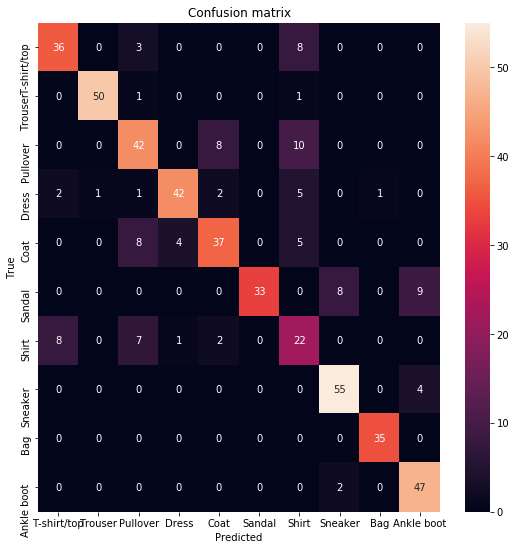

In [29]:
# utility function for plotting confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confmat(y_true, y_pred):
    """
    Plot the confusion matrix and save to user_files dir
    """
    conf_matrix = confusion_matrix(y_true, y_pred)
    fig = plt.figure(figsize=(9,9))
    ax = fig.add_subplot(111)
    sns.heatmap(conf_matrix,
                annot=True,
                fmt='.0f')
    plt.title('Confusion matrix')
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    plt.ylabel('True')
    plt.xlabel('Predicted')
    
plot_confmat(y_test, y_test_pred)    

# Solution 2

In [30]:
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

In [31]:
dists = classifier.compute_distances_no_loops(X_test)
dists.shape

(500, 5000)

In [32]:
y_test_pred = classifier.predict_labels(dists, k=5)

In [33]:
num_test = X_test.shape[0]

num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))


Got 400 / 500 correct => accuracy: 0.800000


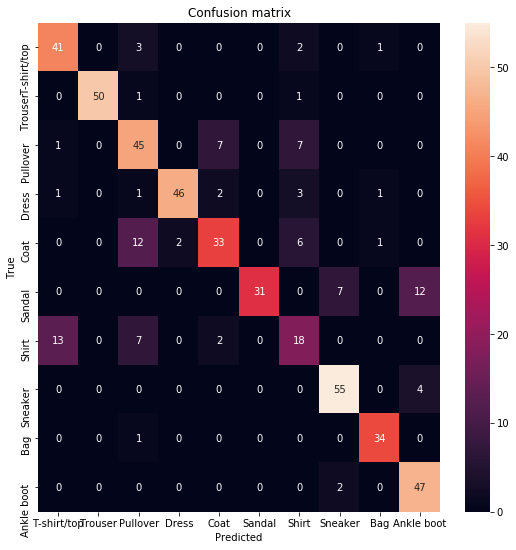

In [34]:
plot_confmat(y_test, y_test_pred) 

# Solution 3

In [35]:
num_folds = 5

k_choices = [1, 4, 5, 10, 12, 18, 20]

X_train_folds = []
y_train_folds = []

In [36]:
num_train = X_train.shape[0]
fold_size = np.ceil(num_train/num_folds).astype('int')

In [37]:
X_train_folds = np.split(X_train, [(i + 1)*fold_size for i in np.arange(num_folds)])
y_train_folds = np.split(y_train, [(i + 1)*fold_size for i in np.arange(num_folds)])

In [38]:
k_to_accuracies = {}

In [39]:
for k in k_choices:
  
  k_to_accuracies[k] = []
  classifier = KNearestNeighbor()
  for i in range(num_folds):
      X_cv_training = np.concatenate([x for k, x in enumerate(X_train_folds) if k!=i], axis=0)
      y_cv_training = np.concatenate([x for k, x in enumerate(y_train_folds) if k!=i], axis=0)
      classifier.train(X_cv_training, y_cv_training)
      dists = classifier.compute_distances_no_loops(X_train_folds[i])
      y_test_pred = classifier.predict_labels(dists, k=k)
      k_to_accuracies[k].append(np.mean(y_train_folds[i] == y_test_pred))
  


In [40]:
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))


k = 1, accuracy = 0.809000
k = 1, accuracy = 0.809000
k = 1, accuracy = 0.812000
k = 1, accuracy = 0.780000
k = 1, accuracy = 0.790000
k = 4, accuracy = 0.811000
k = 4, accuracy = 0.834000
k = 4, accuracy = 0.842000
k = 4, accuracy = 0.806000
k = 4, accuracy = 0.799000
k = 5, accuracy = 0.804000
k = 5, accuracy = 0.828000
k = 5, accuracy = 0.839000
k = 5, accuracy = 0.807000
k = 5, accuracy = 0.805000
k = 10, accuracy = 0.810000
k = 10, accuracy = 0.827000
k = 10, accuracy = 0.832000
k = 10, accuracy = 0.805000
k = 10, accuracy = 0.803000
k = 12, accuracy = 0.808000
k = 12, accuracy = 0.818000
k = 12, accuracy = 0.833000
k = 12, accuracy = 0.802000
k = 12, accuracy = 0.802000
k = 18, accuracy = 0.804000
k = 18, accuracy = 0.810000
k = 18, accuracy = 0.832000
k = 18, accuracy = 0.798000
k = 18, accuracy = 0.791000
k = 20, accuracy = 0.799000
k = 20, accuracy = 0.806000
k = 20, accuracy = 0.822000
k = 20, accuracy = 0.797000
k = 20, accuracy = 0.787000


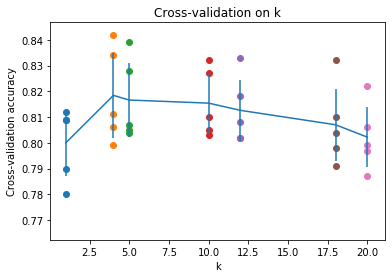

In [42]:
# plot the raw observations
for k in k_choices:
  accuracies = k_to_accuracies[k]
  plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond 
# to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in 
                            sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

# Solution 4

In [43]:
X_train =X_train/255
X_test = X_test/255

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

dists = classifier.compute_distances_no_loops(X_test)
dists.shape

y_test_pred = classifier.predict_labels(dists, k=1)


num_test = X_test.shape[0]

num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))


Got 399 / 500 correct => accuracy: 0.798000


# Solution 5

In [44]:
from numpy.linalg import norm
from numpy import dot

class KNearestNeighbor_cosine():
  """ a kNN classifier with L2 distance """

  def __init__(self):
    pass

  def train(self, X, y):
    """
    Train the classifier. For k-nearest neighbors this is just 
    memorizing the training data.

    Inputs:
    - X: A numpy array of shape (num_train, D) containing the training data
      consisting of num_train samples each of dimension D.
    - y: A numpy array of shape (N,) containing the training labels, where
         y[i] is the label for X[i].
    """
    self.X_train = X.astype('float')
    self.y_train = y
    
  def predict(self, X, k=1):
    """
    Predict labels for test data using this classifier.

    Inputs:
    - X: A numpy array of shape (num_test, D) containing test data consisting
         of num_test samples each of dimension D.
    - k: The number of nearest neighbors that vote for the predicted labels.
    - num_loops: Determines which implementation to use to compute distances
      between training points and testing points.

    Returns:
    - y: A numpy array of shape (num_test,) containing predicted labels for the
      test data, where y[i] is the predicted label for the test point X[i].  
    """
   
    dists = self.compute_distances_two_loops(X)
   

    return self.predict_labels(dists, k=k)

  def compute_distances_two_loops(self, X):
    """
    Compute the distance between each test point in X and each 
    training point in self.X_train using a nested loop over both 
    the training data and the test data.

    Inputs:
    - X: A numpy array of shape (num_test, D) containing test data.

    Returns:
    - dists: A numpy array of shape (num_test, num_train) where 
      dists[i, j] is the Euclidean distance between the ith test 
      point and the jth training point.
    """
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train))
    X = X.astype('float')
    for i in range(num_test):
      for j in range(num_train):
          dists[i, j] = 1 - dot(self.X_train[j,:] , X[i,:])/(norm(self.X_train[j,:])*norm(self.X_train[j,:]))
        
    return dists



  def predict_labels(self, dists, k=1):
    """
    Given a matrix of distances between test points and training points,
    predict a label for each test point.

    Inputs:
    - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
      gives the distance betwen the ith test point and the jth training point.

    Returns:
    - y: A numpy array of shape (num_test,) containing predicted labels for the
      test data, where y[i] is the predicted label for the test point X[i].  
    """
    num_test = dists.shape[0]
    y_pred = np.zeros(num_test, dtype='float64')
    for i in range(num_test):
        # A list of length k storing the labels of the k nearest neighbors to
        # the ith test point.
        closest_y = []
        # get the k indices with smallest distances
        min_indices = np.argsort(dists[i,:])[:k] 
        closest_y = np.bincount(self.y_train[min_indices])
        # predict the label of the nearest example
        y_pred[i] = np.argmax(closest_y)  

    return y_pred



In [45]:
classifier = KNearestNeighbor_cosine()
classifier.train(X_train, y_train)

In [46]:
dists = classifier.compute_distances_two_loops(X_test)
dists.shape

(500, 5000)

In [47]:
y_test_pred = classifier.predict_labels(dists, k=1)

In [48]:
num_test = X_test.shape[0]

num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 192 / 500 correct => accuracy: 0.384000
